In [17]:
import tensorflow as tf
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [18]:
#prepare the data
import pandas as pd
import numpy as np

data = pd.read_csv('data/trainingdata300.csv')
data = data.fillna(method="ffill")
data.tail(10)

,satzId,Wort,Attribut
4928474,55339,start,O
4928475,55339,Load,O
4928476,55339,amount,O
4928477,55339,setting,O
4928478,55339,SAFETY,O
4928479,55339,AND,O
4928480,55339,MAINTENANCE,O
4928481,55339,Lockable,O
4928482,55339,control,O
4928483,55339,panel,O


In [19]:
words = list(set(data["Wort"].values))
n_words = len(words); n_words

103347

In [20]:
tags = list(set(data["Attribut"].values))
n_tags = len(tags); n_tags

7

In [21]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Wort"].values.tolist(),
                                                           s["Attribut"].values.tolist())]
        self.grouped = self.data.groupby("satzId").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    #ToDo: get_next funktioniert nicht richtig, da manche satzIds nicht vorhanden sind
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None


In [22]:
getter = SentenceGetter(data)

In [ ]:
sent = getter.get_next()
print(sent)

None


In [ ]:
sentences = getter.sentences

In [ ]:
# prepare the tokens

max_len = 75
max_len_char = 10

In [16]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

NameError: name 'tags' is not defined

In [13]:
#Beispiele
print(word2idx["Broan"])
print(tag2idx["B-Brand"])

17502
4


In [14]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in sentences]

In [15]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

In [16]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

1838


In [17]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [18]:
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))


In [19]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [20]:
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2021)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2021)

In [23]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

In [24]:
# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(main_lstm)

model = Model([word_in, char_in], out)

In [25]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 10)]     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 75, 10, 10)   18400       input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 75, 20)       2066980     input_1[0][0]                    
______________________________________________________________________________________________

In [27]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=64, epochs=10, validation_split=0.1, verbose=1)

Epoch 1/10
494/494 [==============================] - 100s 142ms/step - loss: 0.4336 - acc: 0.9414 - val_loss: 0.0856 - val_acc: 0.9544
Epoch 2/10
494/494 [==============================] - 68s 138ms/step - loss: 0.0757 - acc: 0.9568 - val_loss: 0.0396 - val_acc: 0.9831
Epoch 3/10
494/494 [==============================] - 68s 137ms/step - loss: 0.0357 - acc: 0.9855 - val_loss: 0.0294 - val_acc: 0.9878
Epoch 4/10
494/494 [==============================] - 66s 134ms/step - loss: 0.0247 - acc: 0.9901 - val_loss: 0.0257 - val_acc: 0.9891
Epoch 5/10
494/494 [==============================] - 66s 133ms/step - loss: 0.0198 - acc: 0.9919 - val_loss: 0.0249 - val_acc: 0.9889
Epoch 6/10
494/494 [==============================] - 66s 134ms/step - loss: 0.0170 - acc: 0.9928 - val_loss: 0.0246 - val_acc: 0.9889
Epoch 7/10
494/494 [==============================] - 65s 132ms/step - loss: 0.0148 - acc: 0.9938 - val_loss: 0.0219 - val_acc: 0.9906
Epoch 8/10
494/494 [==============================] - 

In [28]:
hist = pd.DataFrame(history.history)

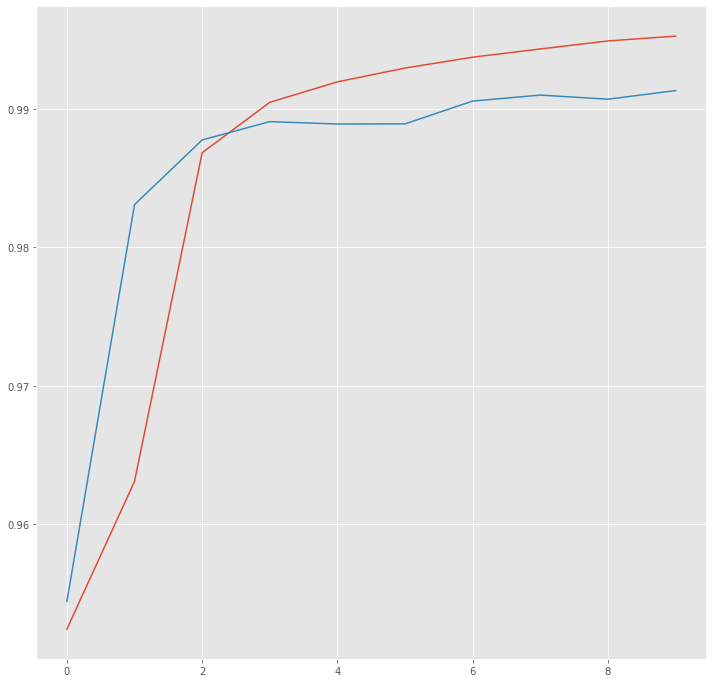

In [29]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [30]:
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])


In [59]:
i = 2016
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))


Word           ||True ||Pred
tefal          : B-Brand B-Brand
blender        : O     O
jug            : O     O
BL2A11         : B-Modelnumber O
(              : O     O
chopper        : O     O
)              : O     O
tefal          : B-Brand B-Brand
blender        : O     O
accessories    : O     O
small          : O     O
jug            : O     O
(              : O     O
chopper        : O     O
)              : O     O
100            : O     O
%              : O     O
original       : O     O
for            : O     O
model          : O     O
BL2A11         : B-Modelnumber O
